In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
## Data
#path_data='/Users/paraskevivourlioti/Documents/NEURALIO/KYKLOS/DATA_KYKLOS/DATA_FOR_TRAINING/SK_agioi10.csv'
path_data='/Users/paraskevivourlioti/Documents/NEURALIO/CLOSED/KYKLOS/DATA_KYKLOS/DATA_FOR_TRAINING/SK_agioi10.csv'

/opt/miniconda3/envs/new_env_tsf/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
import numpy as np
import pandas as pd

# np.random.seed(42)

# # Create a synthetic dataset with three variables
# length = 1000
# t = np.arange(length)
# sine_wave = np.sin(2 * np.pi * 0.01 * t)
# cosine_wave = np.cos(2 * np.pi * 0.01 * t)
# noise = np.random.normal(0, 0.1, size=length)
# # Combine the variables into a single DataFrame
# data = pd.DataFrame({'sine': sine_wave, 'cosine': cosine_wave, 'noise': noise})
data = pd.read_csv(path_data, sep=',')
data = data[['Date','Tmean_2T_agioi10', 'GHIagioi10', 'Yield(Kwh)' ]]
#data = data[['Yield(Kwh)']]
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'])
data_unique = data.drop_duplicates(subset=['Date'], keep='first')
data_unique.set_index('Date', inplace=True)
 
# Calculate monthly and yearly sums and averages
monthly_sum = data_unique.resample('M').sum()
monthly_average = data_unique.resample('M').mean()
yearly_sum = data_unique.resample('A').sum()
yearly_average = data_unique.resample('A').mean()

# Save the data
monthly_sum.to_csv('/Users/paraskevivourlioti/Documents/NEURALIO/PRODUCTS/SOLARIO/monthly_sum.csv')
monthly_average.to_csv('/Users/paraskevivourlioti/Documents/NEURALIO/PRODUCTS/SOLARIO/monthly_average.csv')
yearly_sum.to_csv('/Users/paraskevivourlioti/Documents/NEURALIO/PRODUCTS/SOLARIO/yearly_sum.csv')
yearly_average.to_csv('/Users/paraskevivourlioti/Documents/NEURALIO/PRODUCTS/SOLARIO/yearly_average.csv')
#data_unique['Date'] = pd.to_datetime(data_unique['Date']).dt.strftime('%Y-%m-%d %H:%M:%S')
data_unique.to_csv('/Users/paraskevivourlioti/Documents/NEURALIO/PRODUCTS/SOLARIO/temp_irrad_yield.csv')


In [21]:
from sklearn.model_selection import train_test_split
# Splitting the dataset into train and test/validation
train, test_val = train_test_split(data, test_size=0.3, random_state=42)
# Splitting the test/validation data into separate test and validation sets
test, validation = train_test_split(test_val, test_size=0.5, random_state=42)


In [22]:
# Train a model to make prediction of yield
# Define the target column which we want to predict 
y_col=data['Yield(Kwh)'] # define y variable, i.e., what we want to predict
# Test size is 20 % 
#test_size = int(len(data) * 0.3) # here I ask that the test data will be 10% (0.1) of the entire data
# Train size is the left over 
#train = data.iloc[:-test_size,:].copy() # the copy() here is important, it will prevent us from getting: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_index,col_indexer] = value instead
#test = data.iloc[-test_size:,:].copy()


# print(df.columns)
# Define the predictors, we could use  more than one  predictors in Xtrain: 
X_train=train[['Tmean_2T_agioi10', 'GHIagioi10']].copy()
y_train=train[['Yield(Kwh)']].copy()

In [23]:
## Scale all from 0 to 1 
from sklearn.preprocessing import MinMaxScaler
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)

MinMaxScaler()

In [24]:
scaled_y_train = Yscaler.transform(y_train)
#scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

In [25]:
#  Define the time series input sequence for LSTM: 
# The shape should be (batch_size,n_input,n_features)
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 7 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
# this is important as it created the  sequense bathces 
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
print("Number of predictors ", n_features)

Number of predictors  2


In [26]:
### Prepare Test data 

X_test=test[['Tmean_2T_agioi10', 'GHIagioi10' ]].copy()
y_test=test[['Yield(Kwh)']].copy()
scaled_X_test = Xscaler.transform(X_test)
Yscaler.fit(y_test)
scaled_y_test = Yscaler.transform(y_test)
scaled_y_test = np.insert(scaled_y_test, 0, 0)
scaled_y_test = np.delete(scaled_y_test, -1)

# this genarator thale the true y_test given in test data 
# This will go to the history saving to plot the MSE 

test_generator2 = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=n_input, batch_size=b_size)


In [27]:
# Prepare validation data 
X_val=validation[['Tmean_2T_agioi10', 'GHIagioi10' ]].copy()
y_val=validation[['Yield(Kwh)']].copy()
scaled_X_val = Xscaler.transform(X_val)
Yscaler.fit(y_val)
scaled_y_val = Yscaler.transform(y_val)
scaled_y_val = np.insert(scaled_y_val, 0, 0)
scaled_y_val = np.delete(scaled_y_val, -1)

# this genarator thale the true y_test given in test data 
# This will go to the history saving to plot the MSE 

val_generator = TimeseriesGenerator(scaled_X_val, scaled_y_val, length=n_input, batch_size=b_size)


In [28]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#history= model.fit_generator(generator,epochs=100, verbose=1)
history= model.fit_generator(generator, epochs=100, validation_data=val_generator)
 

Metal device set to: Apple M2
Epoch 1/100


/var/folders/v5/8q98924178x321fcq1591ch00000gn/T/ipykernel_1719/3564939548.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history= model.fit_generator(generator, epochs=100, validation_data=val_generator)
2024-02-19 12:02:30.290166: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


33/33 [==============================] - 4s 67ms/step - loss: 0.1495 - val_loss: 0.0595
Epoch 2/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0574 - val_loss: 0.0481
Epoch 3/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0540 - val_loss: 0.0469
Epoch 4/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0521 - val_loss: 0.0444
Epoch 5/100
33/33 [==============================] - 2s 48ms/step - loss: 0.0498 - val_loss: 0.0413
Epoch 6/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0477 - val_loss: 0.0400
Epoch 7/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0479 - val_loss: 0.0413
Epoch 8/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0451 - val_loss: 0.0368
Epoch 9/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0445 - val_loss: 0.0379
Epoch 10/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0461 - val_loss: 0.0360
Epoch 11/10

33/33 [==============================] - 2s 46ms/step - loss: 0.0407 - val_loss: 0.0325
Epoch 83/100
33/33 [==============================] - 2s 46ms/step - loss: 0.0403 - val_loss: 0.0315
Epoch 84/100
33/33 [==============================] - 2s 47ms/step - loss: 0.0402 - val_loss: 0.0317
Epoch 85/100
33/33 [==============================] - 2s 46ms/step - loss: 0.0404 - val_loss: 0.0309
Epoch 86/100
33/33 [==============================] - 2s 46ms/step - loss: 0.0404 - val_loss: 0.0327
Epoch 87/100
33/33 [==============================] - 2s 46ms/step - loss: 0.0410 - val_loss: 0.0317
Epoch 88/100
33/33 [==============================] - 2s 46ms/step - loss: 0.0400 - val_loss: 0.0318
Epoch 89/100
33/33 [==============================] - 2s 46ms/step - loss: 0.0398 - val_loss: 0.0323
Epoch 90/100
33/33 [==============================] - 2s 46ms/step - loss: 0.0405 - val_loss: 0.0331
Epoch 91/100
33/33 [==============================] - 2s 46ms/step - loss: 0.0401 - val_loss: 0.0323
Epo

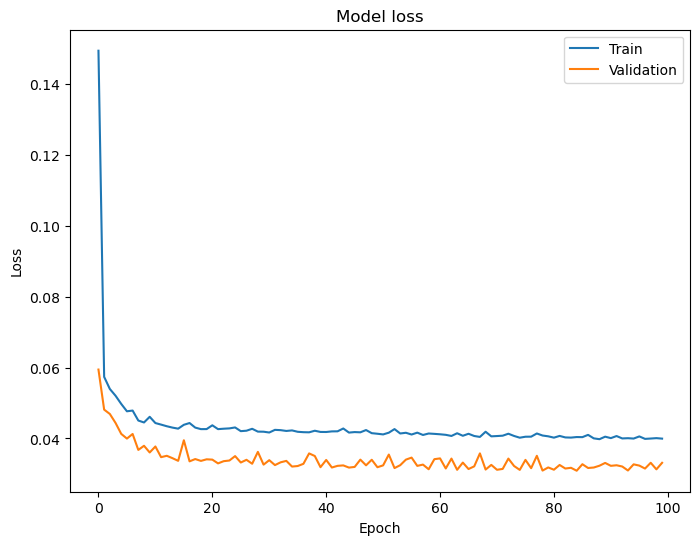

In [29]:
# Plotting the train and validation loss
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6))
values=history.history['loss']
values
plt.plot(values, label='Train Loss')
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.plot(history.history['loss'], label='Train Loss')



7/7 [==============================] - 0s 9ms/step


7/7 [==============================] - 0s 9ms/step


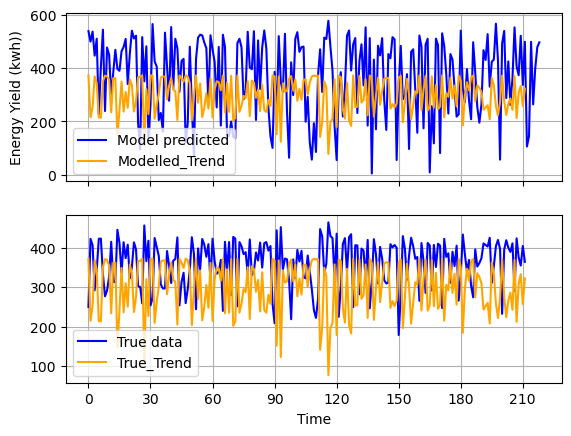

In [60]:
# This generator takes as input np zeros in place of y_test so we can make a prediction with the model
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)


## Make a prediction 
y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'Energy_yield_TRUE':test['Yield(Kwh)'].values[n_input:],'Energy_yield_predicted':y_pred.ravel()})

## Plot the results 

import matplotlib.pyplot as plt

## ---  Plot the MSE over the training epochs
from keras.callbacks import History
y_predicted=results['Energy_yield_TRUE']
y_true_m=results['Energy_yield_predicted']
y_pred2=y_predicted.values 
from matplotlib import pyplot as plt
x = np.arange(len(y_true_m))

 
coef2 = np.polyfit(x, y_true_m, 4)
trend2 = np.polyval(coef2, y_true_m)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
y_true_m2 = y_true_m.values
y_true_m2[-7:] = np.nan
#print(trend)
#trend[-7:] = np.nan
trend_reduced = trend2
trend_reduced[-7:] =np.nan
ax1.plot(y_predicted, color='blue', label='Model predicted')
ax1.plot(trend2, label='Modelled_Trend', color ='orange')
ax1.set_ylabel('Energy Yield (kwh))')
ax1.grid(True)
ax1.legend(loc='lower left')
ax2.plot(y_true_m, color='blue', label='True data' )
ax2.plot(trend_reduced, label='True_Trend', color = 'orange')
ax2.set_xlabel('Time')
ax2.grid(True)

ax2.legend(loc='lower left')
# Adding custom x-ticks to ax1
x_ticks = np.arange(0, len(y_pred2), 30)
ax1.set_xticks(x_ticks)

diff =  y_true_m - y_predicted


#plt.savefig('/Users/paraskevivourlioti/Documents/NEURALIO/KYKLOS/PRESENTATIONS/Pitch_plots/plot_ALLTOGETHER_PREDICTION.png')
 

# Icluding time dimesnion 


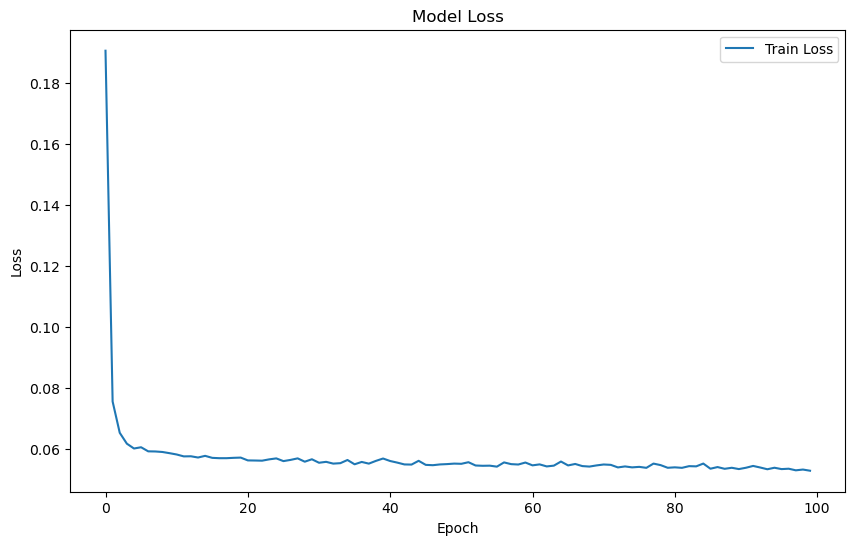

4/4 [==============================] - 0s 10ms/step


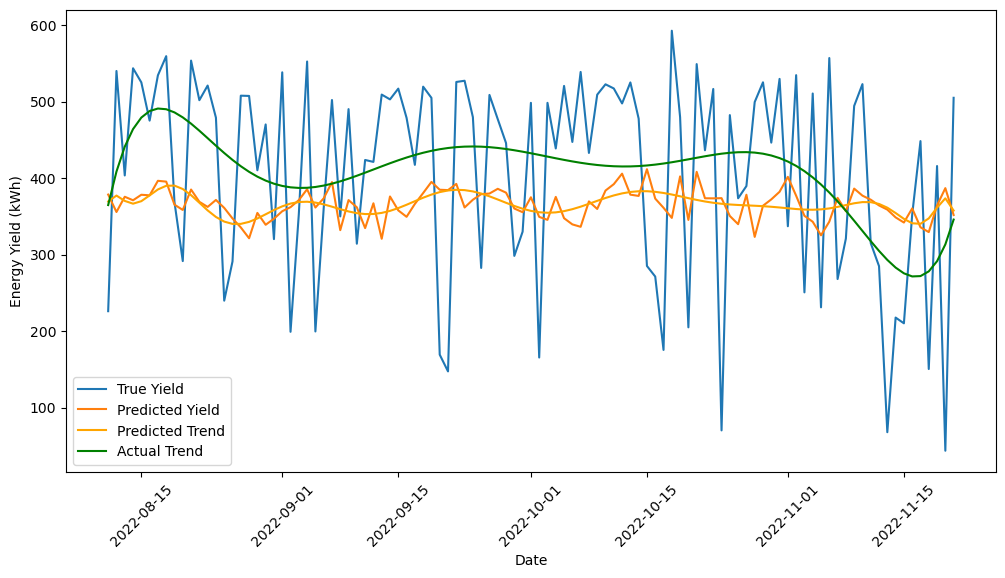

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load and prepare the data
#path_data = '/path/to/your/data.csv'
data = pd.read_csv(path_data, sep=',')
data['Date'] = pd.to_datetime(data['Date'])
data = data.dropna().drop_duplicates(subset=['Date']).set_index('Date')

# Split data into train, test, and validation sets
train, test_val = train_test_split(data, test_size=0.3, random_state=42)
test, validation = train_test_split(test_val, test_size=0.5, random_state=42)

# Prepare training data
X_train = train[['Tmean_2T_agioi10', 'GHIagioi10']]
y_train = train[['Yield(Kwh)']]
Xscaler = MinMaxScaler()
Yscaler = MinMaxScaler()
scaled_X_train = Xscaler.fit_transform(X_train)
scaled_y_train = Yscaler.fit_transform(y_train).ravel()

# Define generator parameters
n_input = 7
b_size = 32
n_features = X_train.shape[1]

# Training generator
train_generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

# Model
#model = Sequential([
#    LSTM(150, activation='relu', input_shape=(n_input, n_features)),
#    Dense(1)
#])
#model.compile(optimizer='adam', loss='mse')

# Fit the model
#history = model.fit(train_generator, epochs=100, verbose=1)

# Plotting training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Prepare test data (scaled)
X_test = test[['Tmean_2T_agioi10', 'GHIagioi10']]
scaled_X_test = Xscaler.transform(X_test)

# Test generator for prediction
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

# Predictions
y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)

# Align predictions with their corresponding dates
prediction_dates = pd.date_range(start=test.index[n_input], periods=len(y_pred), freq='D')
# Change the year of each date in prediction_dates to 2020
prediction_dates = prediction_dates.map(lambda d: d.replace(year=2022))

# Results DataFrame
results = pd.DataFrame({
    'Date': prediction_dates,
    'Energy_yield_TRUE': test['Yield(Kwh)'].values[n_input:],
    'Energy_yield_predicted': y_pred.ravel()
}).set_index('Date')

# Polynomial Trend Calculation
x = np.arange(len(results))
coef2 = np.polyfit(x, results['Energy_yield_predicted'], 16)
trend2 = np.polyval(coef2, x)
# Polynomial Trend for actual 
x = np.arange(len(results))
coef3 = np.polyfit(x, results['Energy_yield_TRUE'], 8)
trend3 = np.polyval(coef3, x)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(results['Energy_yield_TRUE'], label='True Yield')
ax.plot(results['Energy_yield_predicted'], label='Predicted Yield')
ax.plot(prediction_dates, trend2, label='Predicted Trend', color='orange')
ax.plot(prediction_dates, trend3, label='Actual Trend', color='Green')

ax.set_ylabel('Energy Yield (kWh)')
ax.set_xlabel('Date')
ax.legend()
plt.xticks(rotation=45)
plt.show()
# Save
# Assuming 'results', 'trend2' (predicted trend), and 'trend3' (true trend) are already defined

# Add the trends as new columns to the results DataFrame
results['Predicted_Trend'] = trend2
results['True_Trend'] = trend3

# Save the DataFrame to a CSV file
results.to_csv('/Users/paraskevivourlioti/Documents/NEURALIO/PRODUCTS/SOLARIO/trends.csv')


# Here stops the work

In [ ]:
#Outliers removal:
# Function to remove outliers using IQR method
def remove_outliers_iqr(df, columns, factor=1.5):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        print(Q1)
        print(Q3)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        # Filter out the outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df
# Remove outliers from the DataFrame
columns = ['Tmin_2T_agioi10', 'GHIagioi10', 'Yield(Kwh)' ]
columns=['Yield(Kwh)']
df_no_outliers = remove_outliers_iqr(data, columns)
df_no_outliers
for column in columns:
    initial_count = data.shape[0]
    no_outliers_count = df_no_outliers.shape[0]
    num_outliers = initial_count - no_outliers_count
    print(f'Number of outliers in {column}: {num_outliers}')


In [25]:
# Load the autoencoder: 
from tensorflow.keras.models import load_model
# Load the model
loaded_model = load_model('/Users/paraskevivourlioti/Documents/NEURALIO/KYKLOS/DATA_KYKLOS/SCRIPTS/LSTM_autoencoder.h5')

In [ ]:
# Make predictions
# 
y_predicted=results['y_pred']
y_true_m=results['y_true']
#print(y_true)
#print(y_predicted)
reconstructed_data = loaded_model.predict(y_predicted)
#print(predictions)
print(len(reconstructed_data[:][:]))
test_re=reconstructed_data[:][:]
print(type(y_true[:].to_numpy()), type(test_re))
#print(reconstructed_data[:][:])

mse = np.mean(np.power(y_true_m.to_numpy() - reconstructed_data[:][:], 2), axis=(1, 2))
mse_threshold = np.quantile(mse, 0.99)


# Detect anomalies
anomalies = np.where(mse > mse_threshold)
#print(mse)
print(anomalies)




In [ ]:
# Plot the reconstruction errors and anomalies
plt.figure(figsize=(12, 6))
#plt.plot(mse)
#plt.plot(mse)
#print(anomalies[0][:])
#print(anomalies[:][0])
#print(mse[anomalies])
plt.plot=results.plot()
new_y=results['y_true']
markers = [[ new_y[107], new_y[108], new_y[109]   ]]
#plt.plot(anomalies[0][:], mse[anomalies], 'ro', label="Anomalies")
#plt.plot(results['y_true'], 'ro', label="Anomalies")
# Plot the line

plt.scatter(anomalies, markers, color='red', marker='o', label='Precieved anomalies')

#plt.axhline(mse_threshold, linestyle="--", color="gray", label="Threshold")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

# END OF PREDICTION AND AUTOENDOCER 

In [7]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
#data=scaler.fit_transform(df_no_outliers)
# Prepare the input and target data
sequence_length = 7
X, y = [], []
for i in range(len(data) - sequence_length * 2):
    X.append(data[i:i + sequence_length, :])
    y.append(data[i + sequence_length:i + sequence_length * 2, :])

X = np.array(X)
y = np.array(y)





In [8]:
model = Sequential([
    LSTM(64, activation="relu", input_shape=(sequence_length, X.shape[2]), return_sequences=True),
    LSTM(32, activation="relu", return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(32, activation="relu", return_sequences=True),
    LSTM(64, activation="relu", return_sequences=True),
    TimeDistributed(Dense(X.shape[2]))
])

Metal device set to: Apple M2


In [9]:
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVector  (None, 7, 32)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 7, 32)             8320      
                                                                 
 lstm_3 (LSTM)               (None, 7, 64)             24832     
                                                                 
 time_distributed (TimeDistr  (None, 7, 1)             65        
 ibuted)                                                

In [ ]:
#model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1, verbose=1)
history= model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/100


2023-05-12 11:18:05.754731: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


42/42 [==============================] - 10s 204ms/step - loss: 0.2724 - val_loss: 0.1278
Epoch 2/100
42/42 [==============================] - 8s 196ms/step - loss: 0.1129 - val_loss: 0.0693
Epoch 3/100
42/42 [==============================] - 8s 196ms/step - loss: 0.0676 - val_loss: 0.0458
Epoch 4/100
42/42 [==============================] - 8s 197ms/step - loss: 0.0505 - val_loss: 0.0405
Epoch 5/100
42/42 [==============================] - 8s 195ms/step - loss: 0.0489 - val_loss: 0.0402
Epoch 6/100
42/42 [==============================] - 8s 196ms/step - loss: 0.0485 - val_loss: 0.0395
Epoch 7/100
42/42 [==============================] - 8s 196ms/step - loss: 0.0478 - val_loss: 0.0422
Epoch 8/100
42/42 [==============================] - 8s 198ms/step - loss: 0.0488 - val_loss: 0.0399
Epoch 9/100
42/42 [==============================] - 8s 197ms/step - loss: 0.0475 - val_loss: 0.0393
Epoch 10/100
42/42 [==============================] - 8s 198ms/step - loss: 0.0478 - val_loss: 0.0392


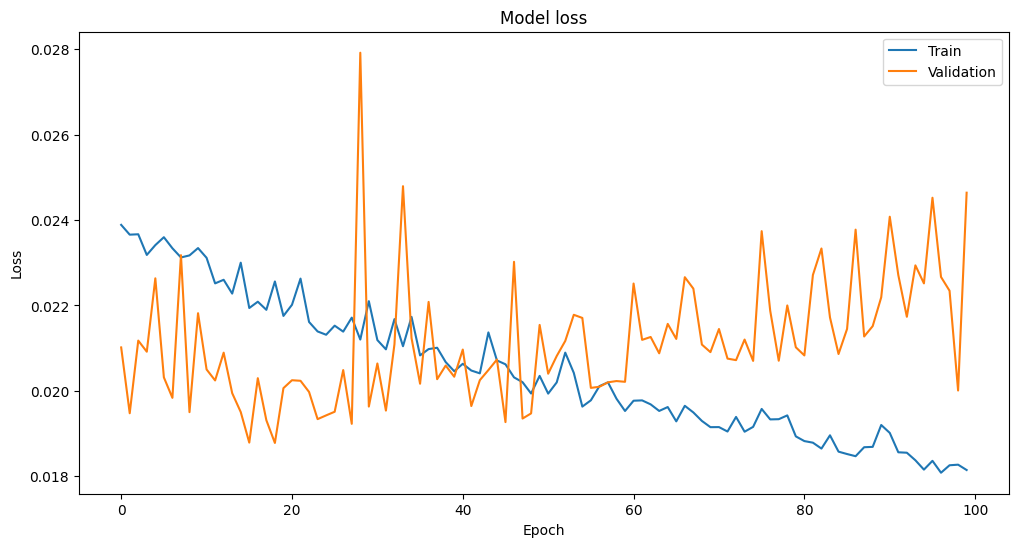

In [51]:
# Plot training and validation loss 
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [52]:
# Compute the reconstruction error for each sample
reconstructed_data = model.predict(X)
#print(reconstructed_data)
mse = np.mean(np.power(X - reconstructed_data, 2), axis=(1, 2))
mse_threshold = np.quantile(mse, 0.99)


47/47 [==============================] - 1s 22ms/step


In [53]:
# Detect anomalies
anomalies = np.where(mse > mse_threshold)


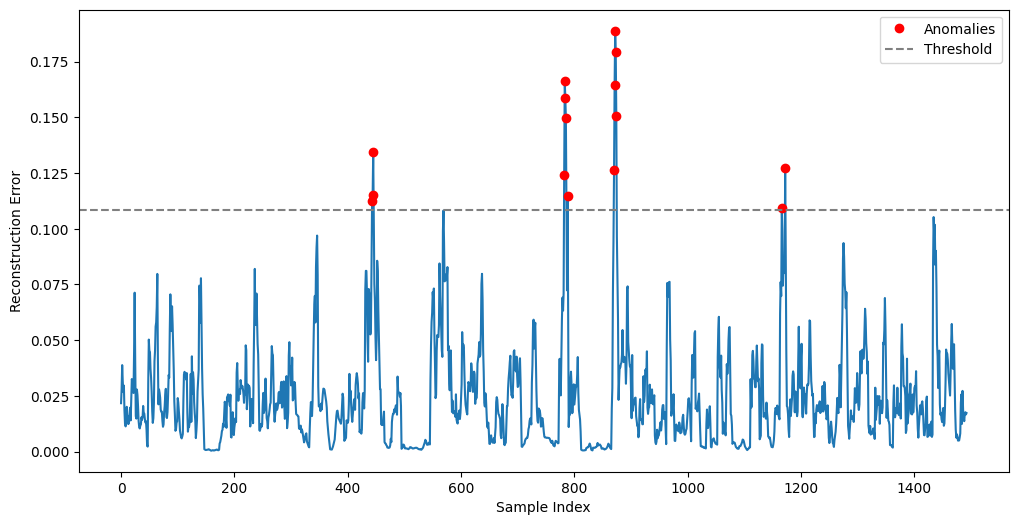

In [54]:
# Plot the reconstruction errors and anomalies
plt.figure(figsize=(12, 6))
plt.plot(mse)
#print(anomalies[0][:])
#print(anomalies[:][0])
#print(mse[anomalies])
plt.plot(anomalies[0][:], mse[anomalies], 'ro', label="Anomalies")
plt.axhline(mse_threshold, linestyle="--", color="gray", label="Threshold")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

# EXAMPLE STOPS HERE

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
#variables=df[['Tmax_2T_agioi10', 'Tmean_2T_agioi10', 'Tmin_2T_agioi10', 'GHIagioi10', 'Yield(Kwh)' ]]
variables=df[['Tmax_2T_agioi10', 'Tmean_2T_agioi10', 'Tmin_2T_agioi10', 'GHIagioi10' ]]
variableY=df[['Yield(Kwh)' ]]
#variables
# Scale the data
scaler = StandardScaler()
scaled_dataX = scaler.fit_transform(variables)
scaled_dataY=scaler.fit_transform(variableY)
# Function to create sequences for LSTM input
def create_sequences(data, sequence_length):
    n_samples, n_features = data.shape
    sequences = np.zeros((n_samples - sequence_length, sequence_length, n_features))
    targets = np.zeros((n_samples - sequence_length, n_features))

    for i in range(sequence_length, n_samples):
        sequences[i - sequence_length] = data[i - sequence_length:i]
        targets[i - sequence_length] = data[i]

    return sequences, targets




In [58]:
# Set sequence length and create sequences
sequence_length = 7
X = create_sequences(scaled_dataX, sequence_length)
y=create_sequences(scaled_dataY, sequence_length)
#print(X)
#print(y)
#ValueError: Dimensions must be equal, 
#but are 1544 and 5 for 
#'{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_3/time_distributed_1/Reshape_1, IteratorGetNext:1)'
#with input shapes: [?,7,1544], [?,5].

In [60]:
# Build the LSTM autoencoder model
model = Sequential([
    LSTM(64, activation="relu", input_shape=(sequence_length, len(variables)), return_sequences=True),
    LSTM(32, activation="relu", return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(32, activation="relu", return_sequences=True),
    LSTM(64, activation="relu", return_sequences=True),
    TimeDistributed(Dense(len(variables)))
])

In [61]:
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 7, 64)             411904    
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 repeat_vector_2 (RepeatVect  (None, 7, 32)            0         
 or)                                                             
                                                                 
 lstm_16 (LSTM)              (None, 7, 32)             8320      
                                                                 
 lstm_17 (LSTM)              (None, 7, 64)             24832     
                                                                 
 time_distributed_2 (TimeDis  (None, 7, 1544)          100360    
 tributed)                                            

In [66]:
# Train the autoencoder
#model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1, verbose=1)
#model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

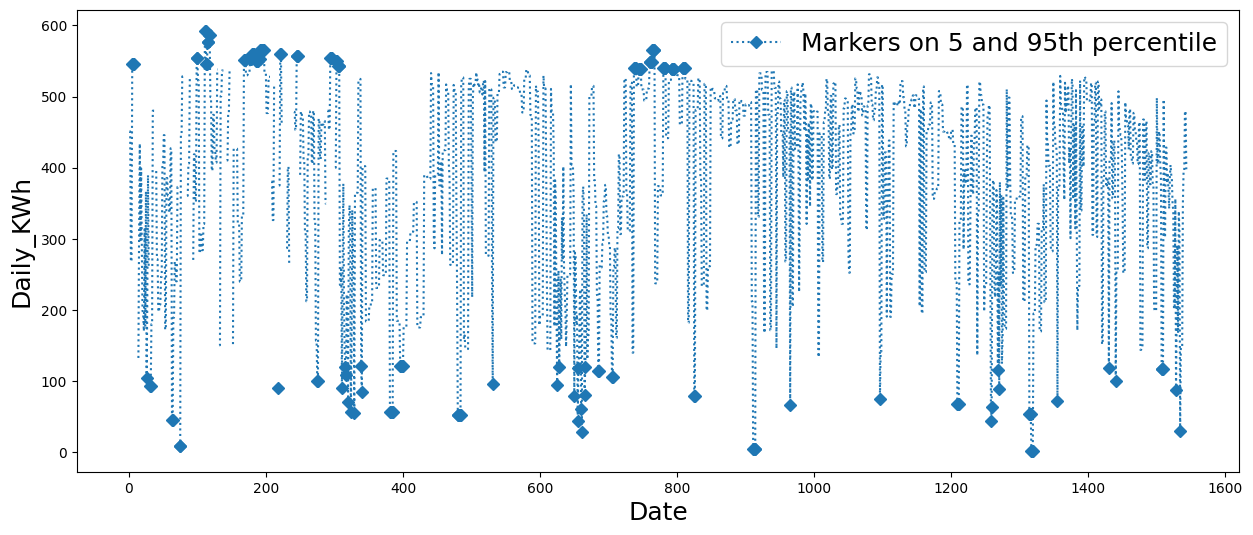

In [14]:
plt.figure(figsize=(15, 6))
#plt.plot(df['Yield(Kwh)'])
label_1=df[df['label']==1]
markers_on=label_1['label']
#print(markers_on.index)
plt.plot(df['Yield(Kwh)'], ':D', markevery=markers_on.index, label='Markers on 5 and 95th percentile')
# Customize the plot, e.g., labels, title, etc.
plt.xlabel("Date", fontsize=18)
plt.ylabel("Daily_KWh", fontsize=18)

#print(label_1)
#print(label_1)
#plt.scatter(label_1['Date'], label_1['Yield(Kwh)'], color='red')
# Display the plot
plt.legend(fontsize=18)
plt.show()


In [32]:
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_blobs
from numpy import quantile, where, random
import matplotlib.pyplot as plt

In [33]:
df['Yield(Kwh)'].value_counts(normalize = True)

Yield(Kwh)
184.610    0.003318
424.630    0.003318
384.330    0.003318
55.830     0.003318
384.660    0.003318
             ...   
135.887    0.000664
280.490    0.000664
276.970    0.000664
181.900    0.000664
397.809    0.000664
Name: proportion, Length: 731, dtype: float64

In [34]:
# Train test split
test_size=int(len(df) * 0.2)
train = df.iloc[:-test_size,:].copy()
test = df.iloc[-test_size:,:].copy()
X=df[['Tmean_2T_agioi10', 'GHIagioi10']]
Y=df[['label']]
X_train=train[['Tmean_2T_agioi10', 'GHIagioi10']].copy()
X_test=test[['Tmean_2T_agioi10', 'GHIagioi10']].copy()
#y_train=train[['label']].copy()
#y_test=test[['label']].copy()

y_train=train[['label']].copy()
y_test=test[['label']].copy()

#y_train=train[['Yield(Kwh)']].copy()
#y_test=test[['Yield(Kwh)']].copy()


from sklearn.preprocessing import MinMaxScaler
## Scale all from 0 to 1 
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
 
scaled_y_train = Yscaler.transform(y_train)
scaled_y_test=Yscaler.transform(y_test)
scaled_X_test = Xscaler.transform(X_test)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
#print(f"The training dataset has {sorted(Counter(scaled_y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")
#Counter(scaled_y_train).items()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





The number of records in the training dataset is 1236
The number of records in the test dataset is 308


In [35]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.01, kernel = 'rbf', gamma = 'auto').fit(scaled_X_train)

In [36]:
# Predict the anomalies
prediction = one_class_svm.predict(scaled_X_test)
prediction

# Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]
scaled_y_test
#prediction
# Check the model performance
print(classification_report(scaled_y_test, prediction))
from sklearn.metrics import precision_score
#print("Precision score: {}".format(precision_score(scaled_y_test,prediction)))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       290
         1.0       0.09      0.06      0.07        18

    accuracy                           0.91       308
   macro avg       0.52      0.51      0.51       308
weighted avg       0.89      0.91      0.90       308



# plot

In [37]:
# Get the scores for the testing dataset
score = one_class_svm.score_samples(scaled_X_test)
#Check the score for 2% of outliers
score_threshold = np.percentile(score, 2)
print(f'The customized score threshold for 2% of outliers is {score_threshold:.2f}')
# Check the model performance at 2% threshold
customized_prediction = [1 if i < score_threshold else 0 for i in score]
# # Check the prediction performance
print(classification_report(scaled_y_test, customized_prediction))

The customized score threshold for 2% of outliers is 8.91
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       290
         1.0       0.14      0.06      0.08        18

    accuracy                           0.93       308
   macro avg       0.54      0.52      0.52       308
weighted avg       0.90      0.93      0.91       308



In [38]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(X_test, columns=['Tmean_2T_agioi10', 'GHIagioi10'])
df_test['y_test'] = y_test
df_test['one_class_svm_prediction'] = prediction
df_test['one_class_svm_prediction_cutomized'] = customized_prediction

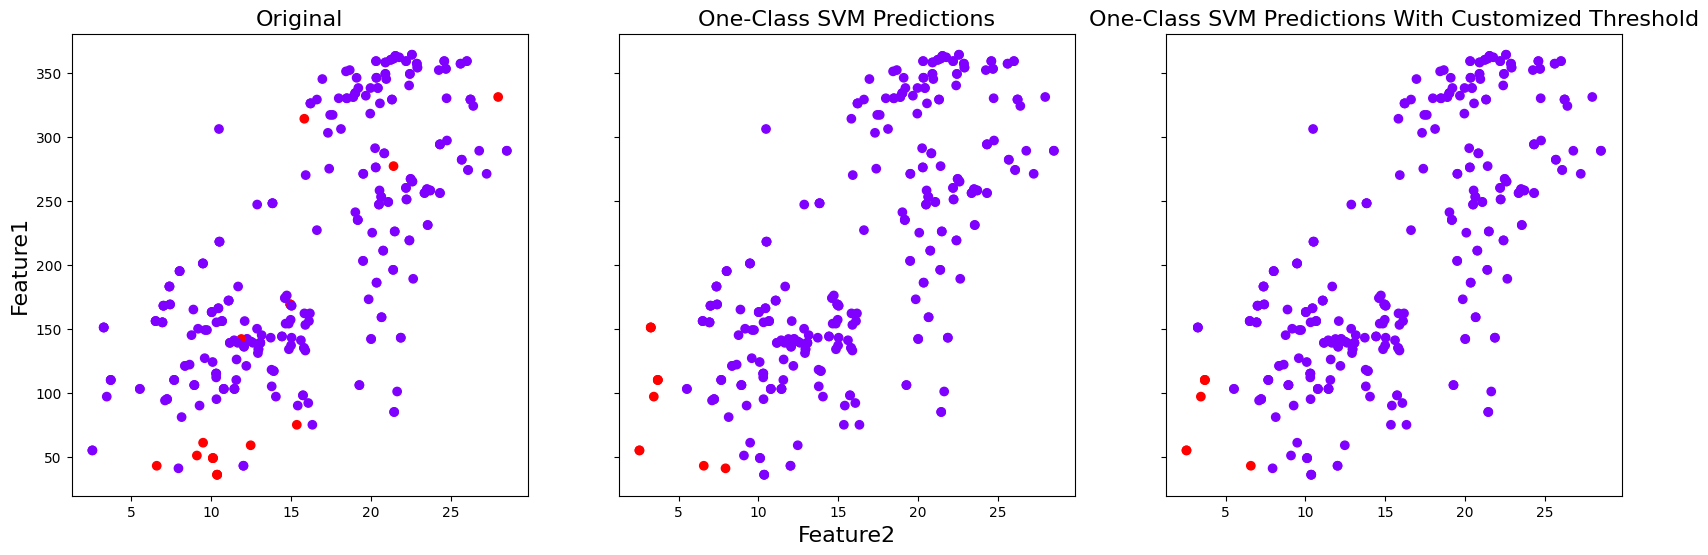

In [43]:
# Visualize the actual and predicted anomalies
fig, (ax0, ax1, ax2)=plt.subplots(1,3, sharey=True, figsize=(20,6))
# Ground truth
ax0.set_title('Original', fontsize=16 )
ax0.set_ylabel('Feature1',fontsize=16)
ax0.scatter(df_test['Tmean_2T_agioi10'], df_test['GHIagioi10'], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions', fontsize=16)
ax1.set_xlabel('Feature2',fontsize=16)
ax1.scatter(df_test['Tmean_2T_agioi10'], df_test['GHIagioi10'], c=df_test['one_class_svm_prediction'], cmap='rainbow')
# One-Class SVM Predictions With Customized Threshold
ax2.set_title('One-Class SVM Predictions With Customized Threshold', fontsize=16)
ax2.scatter(df_test['Tmean_2T_agioi10'], df_test['GHIagioi10'], c=df_test['one_class_svm_prediction_cutomized'], cmap='rainbow')


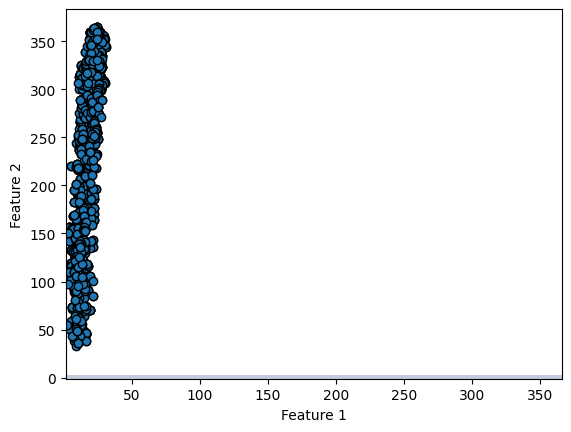

In [318]:
# Create feature plot 
# Create a meshgrid for the feature space
h = 200
#x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x_min, x_max = X.min() - 1, X.max() + 1
y_min, y_max = Y.min() - 1, Y.max() + 1
# x_min=x.min()
# x_max=x.max()
# y_min=y.min()
# y_max=y.max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, h), np.linspace(y_min, y_max, h))

#print(yy)

# Predict the meshgrid using the trained model
Z =  one_class_svm.predict(np.c_[xx.ravel(), yy.ravel()])

# # Plot the learned feature space and decision boundary
Z = Z.reshape(xx.shape)
#plt.contourf(xx, yy, Z, alpha=0.8,cmap=plt.cm.Paired)
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X['Tmean_2T_agioi10'], X['GHIagioi10'], edgecolors='k', marker='o')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
# #print(Z)
# plt.contourf(xx, yy, Z, alpha=0.5)
# #plt.contourf(xx, yy, Z, alpha=0.8)
# #print(X)
# plt.scatter(X['Tmean_2T_agioi10'], X['GHIagioi10'], c=Y.to_numpy(), edgecolors='k', marker='o')
# #plt.scatter(X['Tmean_2T_agioi10'], X['GHIagioi10'], edgecolors='k', marker='o')
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")
# plt.title("Learned Feature Space and Decision Boundary")
# plt.show()

# MUC

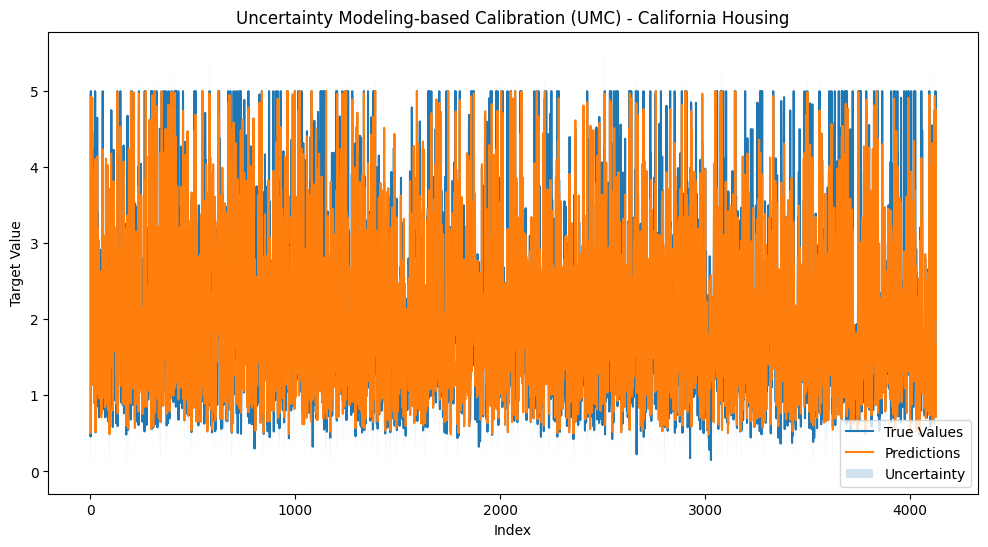

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForestRegressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict the test data
y_pred = rf.predict(X_test)

# Calculate the residuals
residuals = y_test - y_pred

# Model the uncertainty using the standard deviation of the residuals
uncertainty = np.std(residuals)

# Apply UMC by adjusting the predictions based on uncertainty
lower_bound = y_pred - uncertainty
upper_bound = y_pred + uncertainty

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="True Values")
plt.plot(y_pred, label="Predictions")
plt.fill_between(range(len(y_test)), lower_bound, upper_bound, alpha=0.2, label="Uncertainty")
plt.legend()
plt.xlabel("Index")
plt.ylabel("Target Value")
plt.title("Uncertainty Modeling-based Calibration (UMC) - California Housing")
plt.show()


In [97]:
# Create an imbalanced dataset
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)
# Convert the data from numpy array to a pandas dataframe
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})
# Check the target distribution
df['target'].value_counts(normalize = True)

target
0    0.9897
1    0.0103
Name: proportion, dtype: float64

array([0, 0, 0, ..., 0, 0, 0])

In [99]:
X

array([[ 1.23649661,  0.57927154],
       [-0.18872011, -0.02200116],
       [-0.65384426,  0.79430947],
       ...,
       [-0.70049616,  0.30832748],
       [-1.63894133,  0.35149609],
       [-0.43746109,  0.57497027]])

# Example 

In [206]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [216]:
# Create an imbalanced dataset
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)
# Convert the data from numpy array to a pandas dataframe
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})
# Check the target distribution
df['target'].value_counts(normalize = True)
df

,feature1,feature2,target
0,1.236497,0.579272,0
1,-0.188720,-0.022001,0
2,-0.653844,0.794309,0
3,0.005572,0.593370,0
4,0.482573,0.796902,0
...,...,...,...
99995,-1.377568,0.659066,0
99996,-0.252317,0.346224,0
99997,-0.700496,0.308327,0
99998,-1.638941,0.351496,0


In [220]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 80000
The number of records in the test dataset is 20000
The training dataset has 79183 records for the majority class and 817 records for the minority class.


In [218]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.01, kernel = 'rbf', gamma = 'auto').fit(X_train)

In [221]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
print(X_test,prediction, y_test)
# Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]
# Check the model performance
#y_test
#prediction
#print(classification_report(y_test, prediction))

[[-0.3876745   0.37414874]
 [-0.61741094  0.37724596]
 [ 0.43176416  0.19134074]
 ...
 [ 1.32002261  0.82395668]
 [-0.06647413  0.75301896]
 [-1.43329582  0.67679353]] [1 1 1 ... 1 1 1] [0 0 0 ... 0 0 0]


In [211]:
# Get the scores for the testing dataset
score = one_class_svm.score_samples(X_test)
# Check the score for 2% of outliers
score_threshold = np.percentile(score, 2)
print(f'The customized score threshold for 2% of outliers is {score_threshold:.2f}')
# Check the model performance at 2% threshold
customized_prediction = [1 if i < score_threshold else 0 for i in score]
# # Check the prediction performance
print(classification_report(y_test, customized_prediction))

The customized score threshold for 2% of outliers is 182.62
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19787
           1       0.06      0.10      0.07       213

    accuracy                           0.97     20000
   macro avg       0.52      0.54      0.53     20000
weighted avg       0.98      0.97      0.98     20000



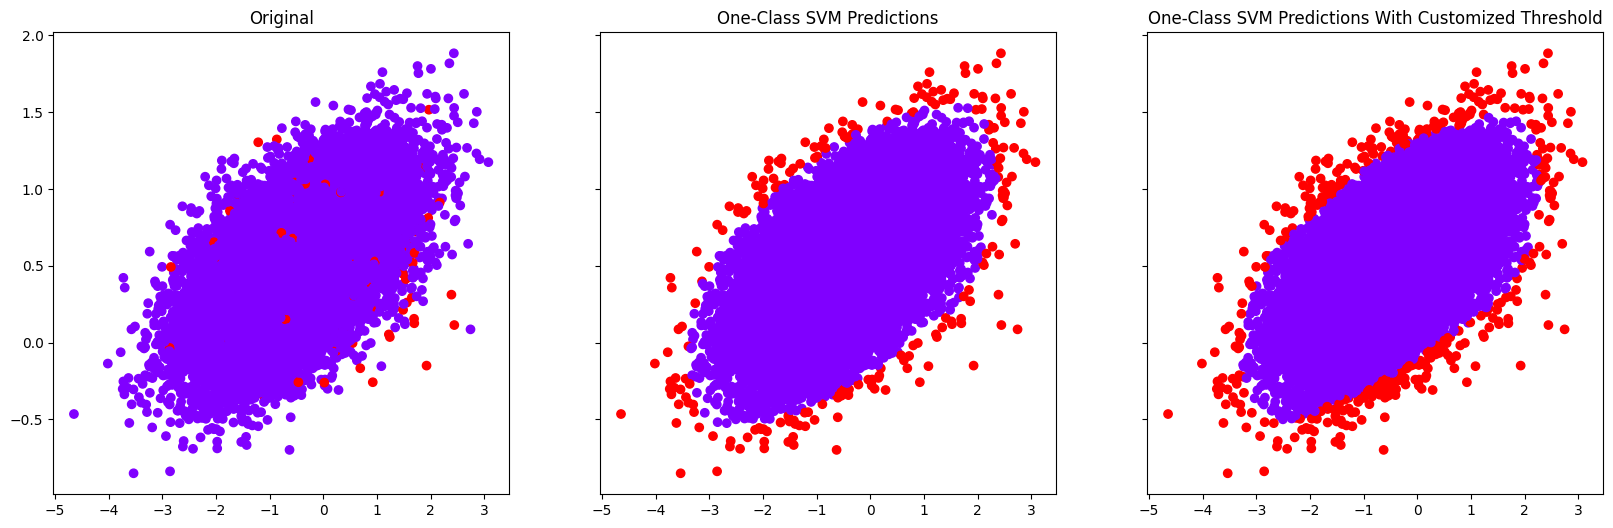

In [212]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
df_test['y_test'] = y_test
df_test['one_class_svm_prediction'] = prediction
df_test['one_class_svm_prediction_cutomized'] = customized_prediction
# Visualize the actual and predicted anomalies
fig, (ax0, ax1, ax2)=plt.subplots(1,3, sharey=True, figsize=(20,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')
# One-Class SVM Predictions With Customized Threshold
ax2.set_title('One-Class SVM Predictions With Customized Threshold')
ax2.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction_cutomized'], cmap='rainbow')

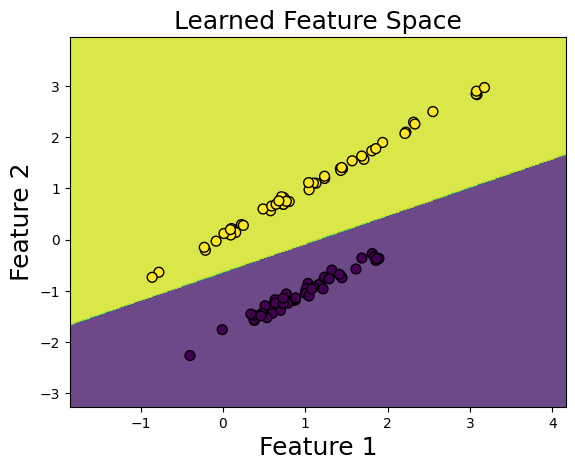

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Create a synthetic dataset with 2 features
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=42, n_clusters_per_class=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Create a meshgrid for the feature space
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the meshgrid using the trained model
Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

# Plot the learned feature space and decision boundary
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50)
plt.xlabel("Feature 1", fontsize=18)
plt.ylabel("Feature 2",fontsize=18)
#plt.title("Learned Feature Space and Decision Boundary", fontsize=18)
plt.title("Learned Feature Space", fontsize=18)
plt.show()
